# SiPM Showers

#### 1) Select events using a run's DST file -- > 2) Look at those events' waveforms

Here, I use this notebook to look at the waveforms of sodium events near the photoelectric peak

In [3]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-02 18:01:06


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import os
import time
import tables as tb
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from invisible_cities.database import load_db
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units
from invisible_cities.core.core_functions import in_range
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.reco.pmaps_functions import plot_s12

sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
from icaro.core.event_pmaps     import EventPmaps, print_s12, print_s2si
from icaro.core.kdst_functions  import load_dst, event_rate, profile_and_fit, print_fit, chi2
from icaro.core.hst_functions   import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                                     doublescatter, covariance, reso, gausstext, plot_profile_histogram 

NameError: name 'xs' is not defined

### Run Parameters

In [7]:
run_number =  3741
#run_number =  3614
# consecutive! could do a little more work and make them not have to be consecutive
if run_number == 3741: subruns = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']
if run_number == 3614: subruns = ['2000', '2001', '2002', '2003']

In [8]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [9]:
def find_sipms(x, y, rmax, rmin=None):
    # [rmin, rmax)
    f_sipms = np.where(np.sqrt((x-xs)**2 + (y-ys)**2) <= rmax)[0]
    if rmin is not None: 
        return np.array(list(set(np.where(np.sqrt((x-xs)**2 + (y-ys)**2) >= rmin)[0]) & set(f_sipms)))
    else:
        return f_sipms

    
# TEST find sipms
txc   =-30*units.mm
tyc   =  5*units.mm
trmin = 20*units.mm
trmax = 50*units.mm
testsipms = find_sipms(txc, tyc, trmax, rmin=trmin)

# Make sure it only returns SiPMs within rmin and rmax
for tsipm in testsipms:
    assert np.sqrt((xs[tsipm] - txc)**2 + (ys[tsipm] - tyc)**2) < trmax
    assert np.sqrt((xs[tsipm] - txc)**2 + (ys[tsipm] - tyc)**2) >= trmin
    
# Make sure it does not reject any SiPMs within rmin and rmax 
for isipm in range(len(xs)):
    if isipm not in testsipms:
        assert np.sqrt((xs[isipm] - txc)**2 + (ys[isipm] - tyc)**2) >= trmax or\
               np.sqrt((xs[isipm] - txc)**2 + (ys[isipm] - tyc)**2) < trmin

Define External SiPMs

In [10]:
nsipm = 1792
ext_t = 170 * units.mm
ext_sipms = np.where(np.sqrt(xs **2 + ys ** 2) > ext_t)[0]
mask            = np.ones_like(xs, dtype=bool)
mask[ext_sipms] = False
int_sipms = np.where(mask)[0]
assert       len(int_sipms) + len(ext_sipms)  == 1792
assert  list(set(int_sipms) | set(ext_sipms)) == list(range(nsipm))
print(len(int_sipms), len(ext_sipms))

912 880


### 1) HAVE ACCESS TO WVFMS FROM CONSECTIVE SUBRUNS

In [11]:
## consecutive meaning subrun 025, 026, 027... for ex

RWF_path = os.path.join(os.environ['IC_DATA'], 'LSC/wvfms/{}/'.format(run_number))
RWF_files = [RWF_path + 'dst_waves.gdcsnext.{}_{}.root.h5'.format(subrun, run_number) for subrun in subruns]
print(RWF_files)

['/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.000_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.001_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.002_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.003_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.004_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.005_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.006_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.007_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.008_3741.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3741/dst_waves.gdcsnext.009_3741.root.h5']


### 2) FIND STARTING AND FINAL EVENT IN THESE SUBRUNS

In [12]:
startfile = tb.open_file(RWF_files[0],'r')
sev = startfile.root.Run.events[0][0]
startfile.close()

endfile = tb.open_file(RWF_files[-1],'r')
fev = endfile.root.Run.events[-1][0]
endfile.close()
print('These subruns include events in this (inclusive) range: ')
print(sev, fev)

These subruns include events in this (inclusive) range: 
1 1680


In [13]:
ifile = os.path.join(os.environ['IC_DATA'],
                        'LSC/kdst/{}/dst_{}.root.h5'.format(run_number,run_number))
print("ifile:", ifile)
full = load_dst(ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3741/dst_3741.root.h5


## 3) Select events in dst in these subruns
also can make other cuts 

In [14]:
srs  = full[in_range(full.event, sev, fev)] # events from this subrun
srsc = srs [srs .nS2 ==1]                   # events with one S2
srsc = srsc[srsc.peak==0]                   # events with one S1
print(len(srs), len(srsc))
srsc

1149 1149


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.492761e+09,0,1,325.0,291.784790,1633.281848,402950.0,19.269625,11846.543945,...,656437.5,23,253.4875,253.4875,-101.626026,-80.719748,129.782614,-2.470348,9.995454,10.260890
1,4,1.492761e+09,0,1,300.0,346.041962,1987.342845,197750.0,11.931250,1895.457764,...,655937.5,10,458.1875,458.1875,-172.932161,-104.498722,202.053248,-2.598035,7.994987,7.479202
2,8,1.492761e+09,0,1,325.0,241.086731,1357.621291,540125.0,14.100687,13788.837891,...,654412.5,31,114.2875,114.2875,-33.703098,-177.762517,180.929299,-1.758169,10.977166,11.139350
3,9,1.492761e+09,0,1,325.0,268.457001,1512.499724,458825.0,10.919187,8124.619141,...,655262.5,21,196.4375,196.4375,145.547535,-105.859495,179.973102,-0.628827,9.801901,9.583662
4,10,1.492761e+09,0,1,325.0,256.425323,1448.007703,555700.0,12.232500,13821.969727,...,654737.5,28,99.0375,99.0375,82.532145,153.325685,174.127311,1.076996,10.849064,10.345228
5,11,1.492761e+09,0,1,300.0,236.392654,1367.271219,557825.0,23.222188,21954.177734,...,654537.5,29,96.7125,96.7125,-7.284021,-27.472463,28.421703,-1.829972,10.221262,10.407341
6,12,1.492761e+09,0,1,275.0,323.694824,1759.706444,539125.0,25.389875,12705.061523,...,655562.5,36,116.4375,116.4375,-40.212259,173.991512,178.577916,1.797925,10.736340,11.617869
7,13,1.492761e+09,0,1,325.0,342.013977,1993.519785,423300.0,24.256812,14017.745117,...,655462.5,23,232.1625,232.1625,-22.520714,50.549097,55.338899,1.989920,10.409032,9.943912
8,15,1.492761e+09,0,1,300.0,218.462860,1252.479419,603675.0,19.163625,26142.890625,...,653412.5,30,49.7375,49.7375,39.656301,-6.990661,40.267749,-0.174489,10.709655,10.035420
9,16,1.492761e+09,0,1,300.0,313.378143,1730.589759,347450.0,13.209687,8368.445312,...,656062.5,20,308.6125,308.6125,48.566262,78.003260,91.886835,1.013911,9.684707,9.996993


In [15]:
s1par  = S12Params(tmin=  0*units.mus, tmax=649*units.mus, stride= 4, lmin= 5, lmax=   30, rebin=False)
s2par  = S12Params(tmin=649*units.mus, tmax=700*units.mus, stride=80, lmin=80, lmax=20000, rebin=True)
thr    = ThresholdParams(thr_s1=3*units.pes,  thr_s2=1*units.pes,
                         thr_MAU=3*units.adc, thr_sipm = .5 * units.pes,
                         thr_SIPM=30*units.adc)
epm = EventPmaps(run_number, s1par, s2par, thr, verbose=False)

In [16]:
MEVTS          = 10
nsipm          = 1792
npmt           = 11
region_len_mus = 700

sipm_sum     = np.zeros((MEVTS, nsipm, 1300), dtype=np.float32)
pmt_sum      = np.zeros((MEVTS, npmt , 52000), dtype=np.float32)

hot_t  =  7.1*units.mm
warm_t = 20  *units.mm
#cold_t = 131*units.mm

CUTS2=100
si_hot = []
si_hotc = []
#si_warm = []
#si_warmc = []
si_cold = []
si_coldc = []

Aswf         = np.zeros((nsipm, region_len_mus), dtype=np.float32)
Bswf         = np.zeros((nsipm, region_len_mus), dtype=np.float32)

siwf_hot      = []
siwf_warm     = []
siwf_cold     = []

Aswf_pmt     = np.zeros((npmt, int(region_len_mus * units.mus / 25)), dtype=np.float32)
Bswf_pmt     = np.zeros((npmt, int(region_len_mus * units.mus / 25)), dtype=np.float32)

Apes_pmt = []
Bpes_pmt = []
Apes     = []
Aext_pes = []
Aint_pes = []
At       = []

Bpes  = []
Bspes = []
Bfpes = []
Bt    = []

Bext_pes = []
Bint_pes = []

pevts = 0
for subrun in RWF_files:
    if pevts == MEVTS: break
    h5rwf = tb.open_file(subrun,'r')
    pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
    NEVT, NPMT, PMTWL = pmtrwf.shape
    NEVT, NSIPM, SIPMWL = sipmrwf.shape
    print("""
            Number of events in file = {}
            Number of PMTs = {}
            PMTWL = {}
            Number of SiPMs = {}
            SiPMWL = {}
          """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))
    
    # Select desired waveforms
    assert(NEVT == h5rwf.root.Run.events[-1][0] - h5rwf.root.Run.events[0][0] + 1)
    ssev = h5rwf.root.Run.events[0][0]
    sfev = h5rwf.root.Run.events[-1][0]
    sr = srs[in_range(srs.event, ssev, sfev)]
    srevents = np.array(list(set(sr.event.values)))
    srinds = srevents - ssev
    spmtrwf = np.array(pmtrwf) [srinds]
    ssipmrwf= np.array(sipmrwf)[srinds]
    
    print('IC Alpha Candidates in this subrun: ', len(ssipmrwf))
    
    for evi in range(len(spmtrwf)):
        
        # Run IC
        epm.calibrated_pmt_and_csum(evi, spmtrwf)
        epm.calibrated_sipm(evi, ssipmrwf, calwf=True)
        epm.find_s1()
        epm.find_s2()
        epm.find_s2si()
        
        # Record wfm
        sipm_sum[pevts] += ssipmrwf[pevts]
        pmt_sum [pevts] += epm.CAL_PMT

        
        # Sum of whole waveforms
        pmt_sum[pevts]        += epm.CAL_PMT
        #sipm_sum[pevts]       += epm.sipm
        sipm_sum[pevts]       += ssipmrwf[pevts]
        
        # Find Hot and Cold SiPMs
        event_num = srevents[evi]
        bx = srsc[srsc.event == event_num].X.values[0]
        by = srsc[srsc.event == event_num].Y.values[0]
        si_hot_i  = find_sipms(bx, by,  hot_t, rmin=None)
        si_warm_i = find_sipms(bx, by, warm_t, rmin=hot_t)
        si_cold_i = find_sipms(bx, by,  1.0e6, rmin=warm_t)
        siwf_hot.append(ssipmrwf [pevts][si_hot_i ])
        siwf_warm.append(ssipmrwf[pevts][si_warm_i])
        siwf_cold.append(ssipmrwf[pevts][si_cold_i])
        
        # Find A and B regions (ns)
        tbuf   = 1 * units.mus
        Atimes = np.array([epm.S1[0][0][-1] + tbuf, epm.S2[0][0][0] - tbuf], dtype=np.float32)
        Btimes = np.array([epm.S2[0][0][-1] + tbuf, 1300000         - tbuf], dtype=np.float32)
        Ai     = np.array(np.ceil(Atimes / units.mus), dtype=np.int32) # indices of sipm wvfm (same as time in mus)
        Bi     = np.array(np.ceil(Btimes / units.mus), dtype=np.int32)
        regA   = epm.sipm[:, Ai[0]: Ai[1]+1]
        regB   = epm.sipm[:, Bi[0]: Bi[1]+1]
        
        # Get cumulative waveform of PMTs (a kind of positive control)
        Ai_pmt   = np.array(Ai * units.mus / 25.0 * units.ns, dtype=np.int32)
        Bi_pmt   = np.array(Bi * units.mus / 25.0 * units.ns, dtype=np.int32)
        regA_pmt = epm.CAL_PMT[:, Ai_pmt[0]: Ai_pmt[1]+1]
        regB_pmt = epm.CAL_PMT[:, Bi_pmt[0]: Bi_pmt[1]+1]
        Aswf_pmt[:, :regA_pmt.shape[1]] += regA_pmt
        Bswf_pmt[:, :regB_pmt.shape[1]] += regB_pmt
        
        # Add A and B regions to Aswf and Bswf 
        Aswf[:, :regA.shape[1]] += regA
        Bswf[:, :regB.shape[1]] += regB
        
        # Record pes in these regions
        Apes.append(regA.sum(axis=1))
        Bpes.append(regB.sum(axis=1))
        Apes_pmt.append(regA_pmt.sum(axis=1))
        Bpes_pmt.append(regB_pmt.sum(axis=1))
        
        # Compute pes in internal and external SiPMs
        At.append(regA.shape[1])                           # length in mus of reg
        Aext_pes.append(Apes[-1][ext_sipms].mean())        # pes per SiPM in ext sipms      
        Aint_pes.append(Apes[-1][int_sipms].mean())        # pes per sipm in int sipms
        
        Bt.append(regB.shape[1])
        Bext_pes.append(Bpes[-1][ext_sipms].mean())
        Bint_pes.append(Bpes[-1][int_sipms].mean())
        Bspes.append(regB[:, :int(round(regB.shape[1] / 2.0))].sum()) # count pes in first half of regB
        Bfpes.append(np.sum(Bpes[-1]) - Bspes[-1])                    # in second half of regB
        pevts += 1
        
        if pevts == MEVTS: break
            
            
    h5rwf.close()
    #break




            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  116


In [17]:
At   =np.array(At)   
Apes =np.array(Apes)
Bpes =np.array(Bpes)
Bspes=np.array(Bspes)
Bfpes=np.array(Bfpes)
Bt   =np.array(Bt)
Aext_pes = np.array(Aext_pes) 
Aint_pes = np.array(Aint_pes) 
Bext_pes = np.array(Bext_pes) 
Bint_pes = np.array(Bint_pes)  
Apes_pmt = np.array(Apes_pmt)
Bpes_pmt = np.array(Bpes_pmt)
siwf_hot  = np.array(siwf_hot)
siwf_warm = np.array(siwf_warm)
siwf_cold = np.array(siwf_cold)

In [18]:
print('NEVTS processed: ', pevts)

NEVTS processed:  10


#### PEs in region A vs region B

In [ ]:
plt.figure(figsize=(15,5))
nza = np.nonzero(At)[0]
r=(0.03,.06)

bins=pevts*4
plt.hist(Apes.mean(axis=1)[nza] / At[nza], bins = bins, alpha=.5, range=r, label='RegA: between S1 and S2')
plt.hist(Bpes.mean(axis=1)      / Bt     , bins = bins, alpha=.5, range=r, label='RegB: after S2')
plt.xlabel('PEs after S2 / SiPM / mus')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
r=(-.5,.5)
plt.hist(Apes_pmt.mean(axis=1)[nza] / At[nza], bins = bins, alpha=.5, range=r, label='RegA: between S1 and S2')
plt.hist(Bpes_pmt.mean(axis=1)      / Bt     , bins = bins, alpha=.5, range=r, label='RegB: after S2')
plt.xlabel('PEs after S2 / Pmt / mus')
plt.legend()
plt.grid(True)
plt.show()

All waveforms

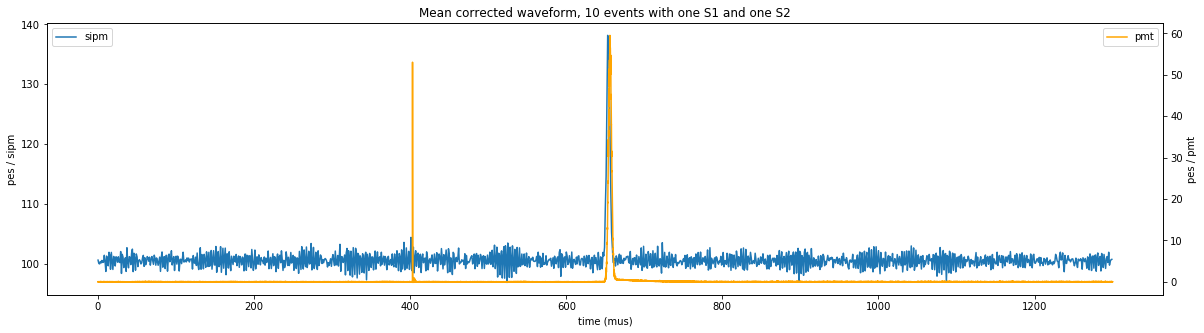

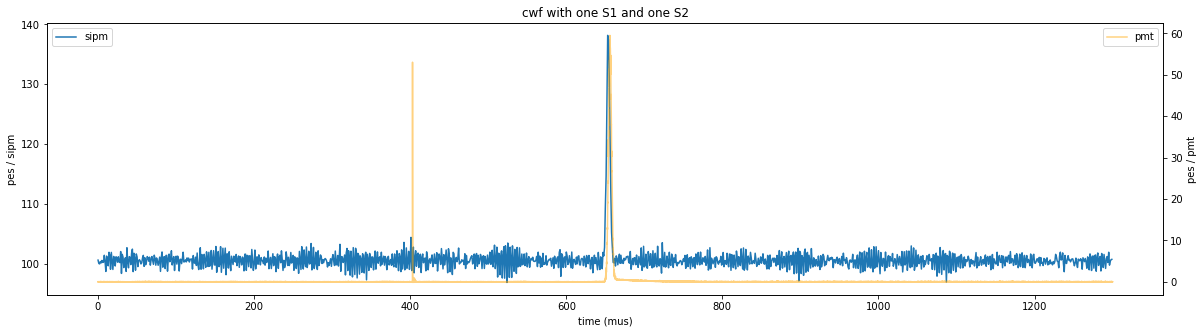

1892
2 11 1779


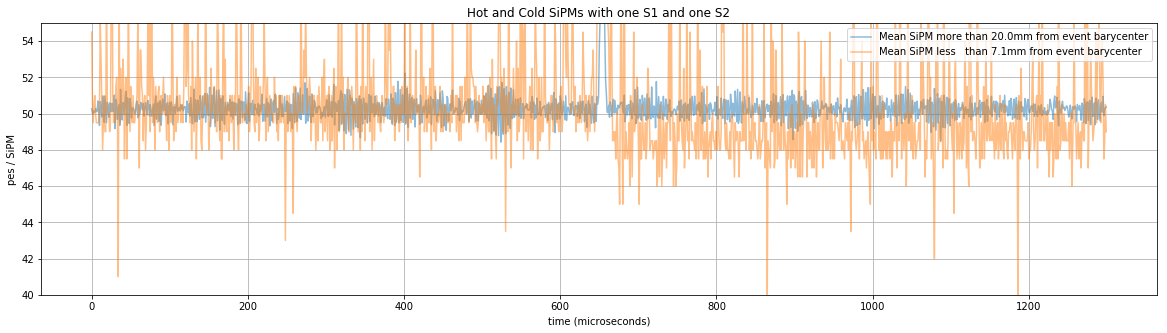

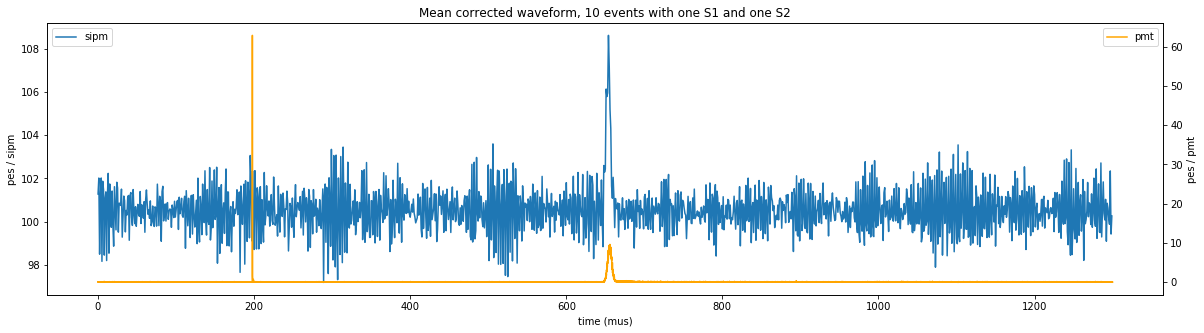

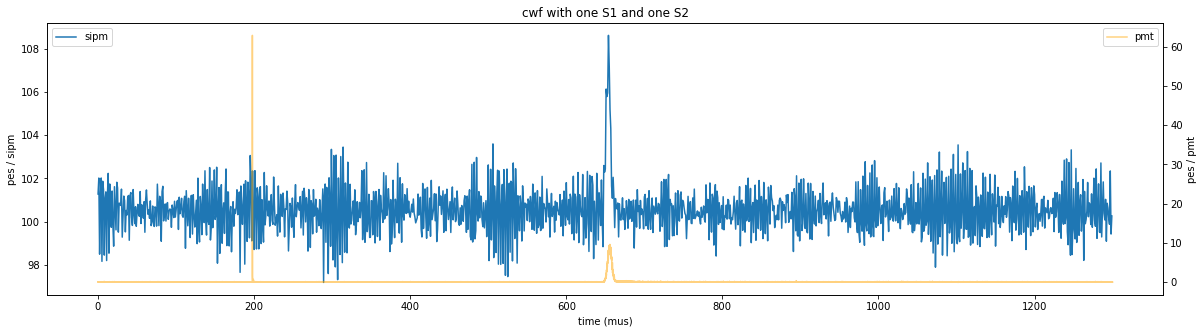

456
1 10 1781


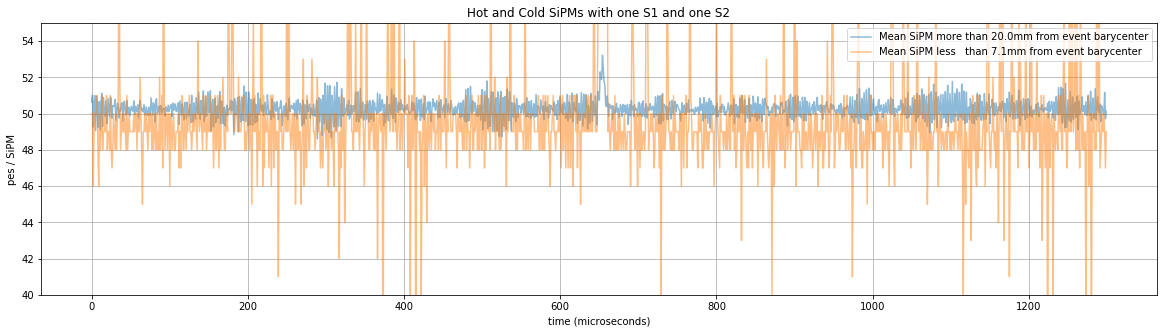

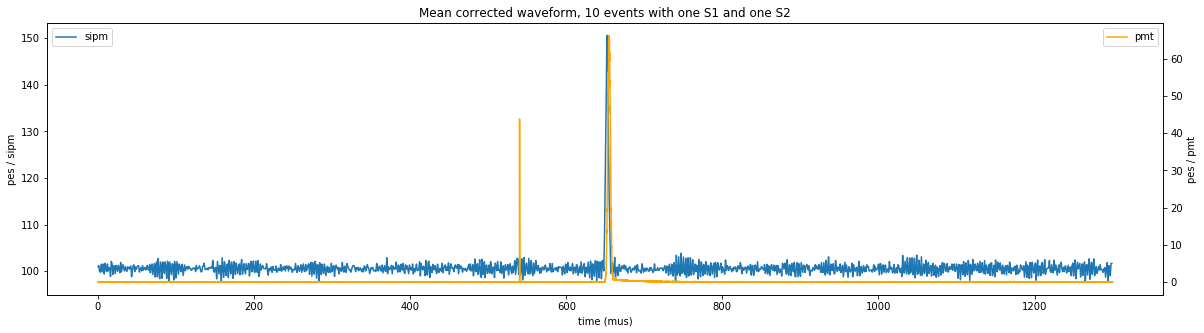

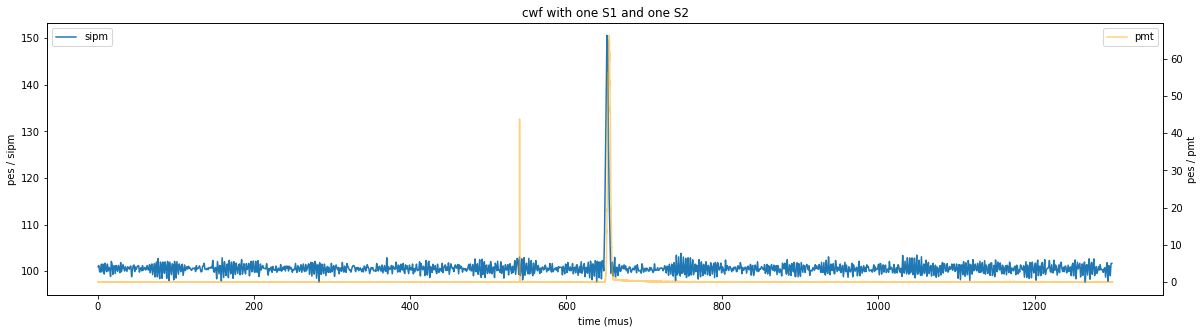

3353
1 11 1780


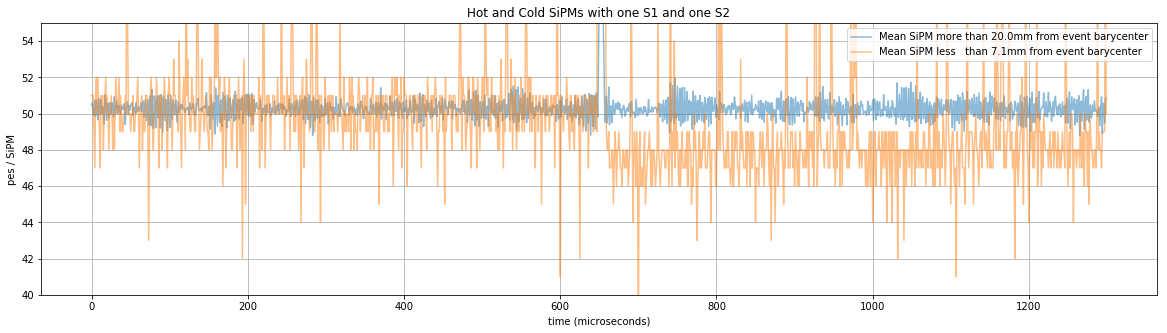

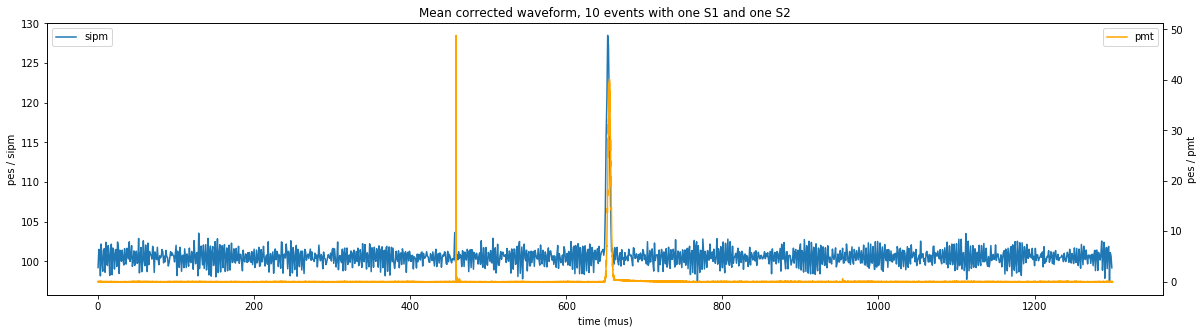

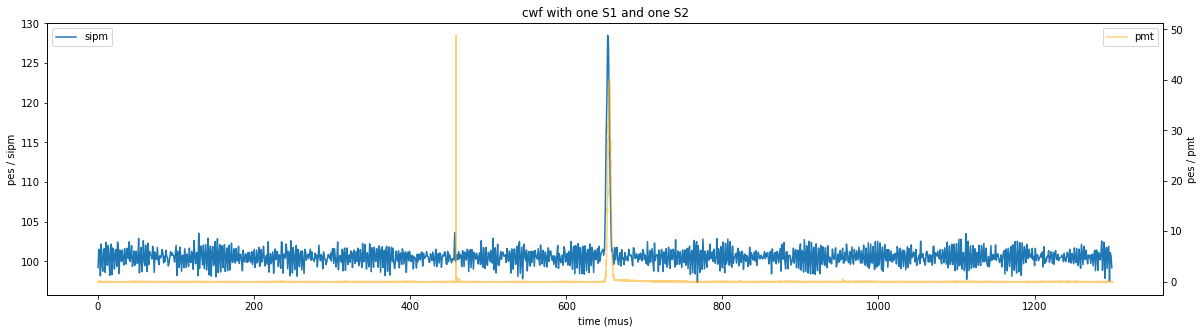

1970
1 10 1781


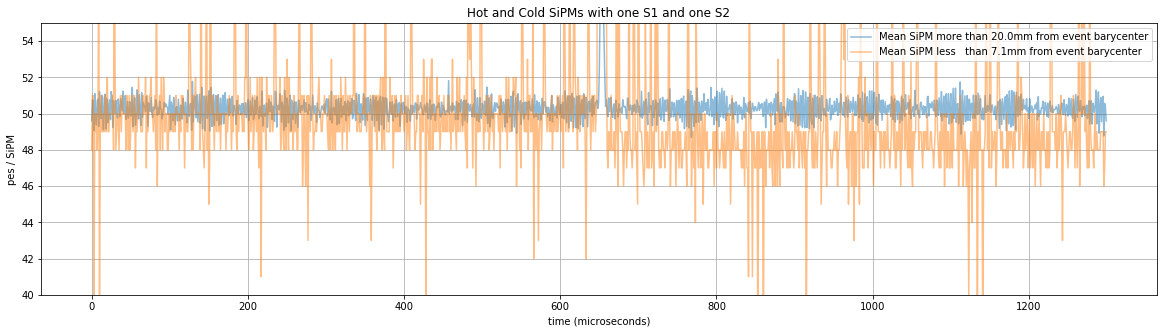

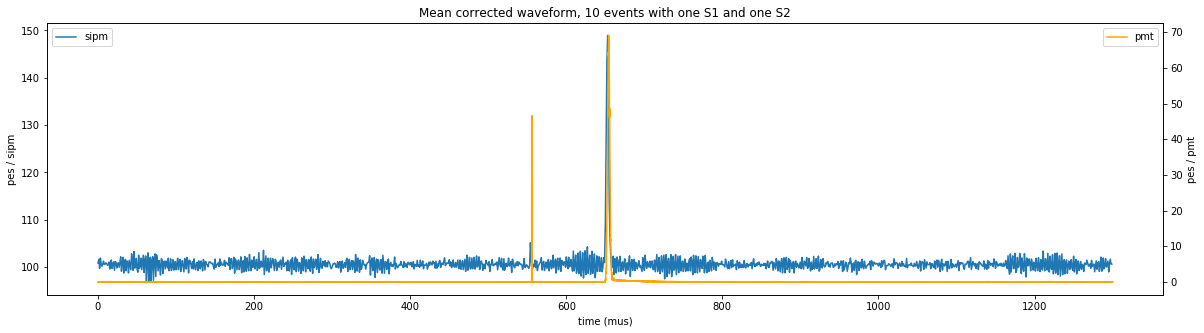

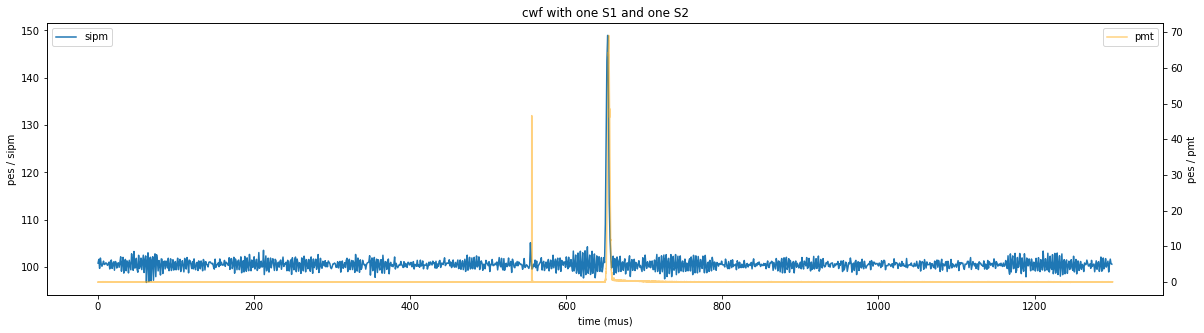

3088
1 12 1779


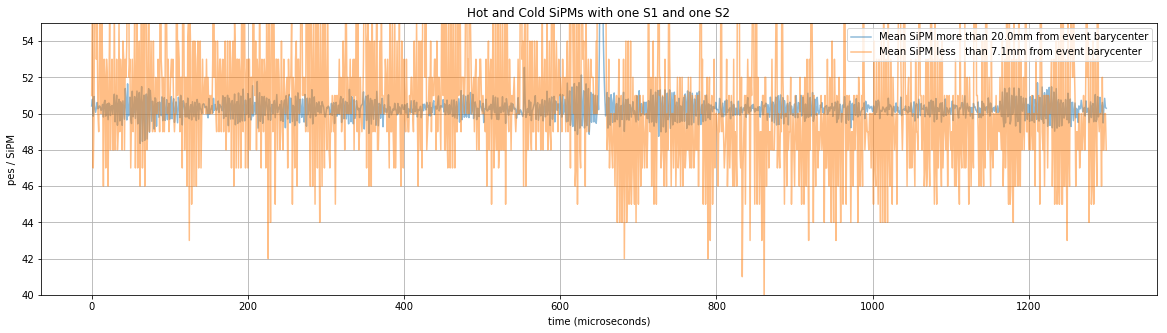

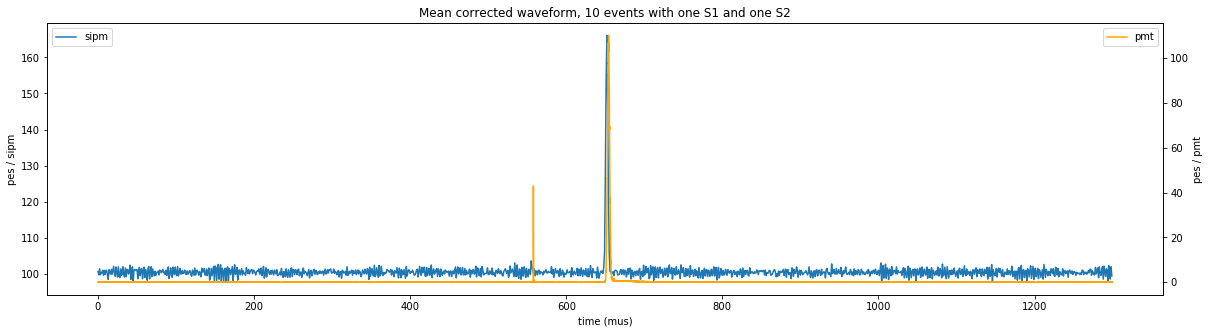

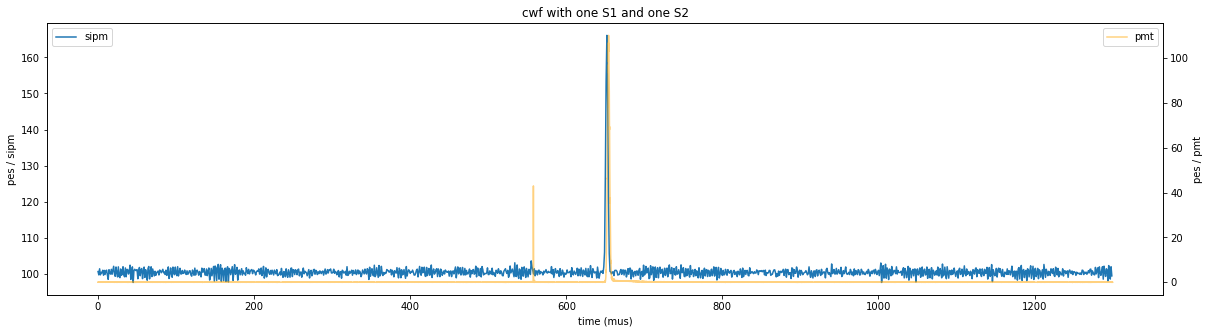

3759
1 12 1779


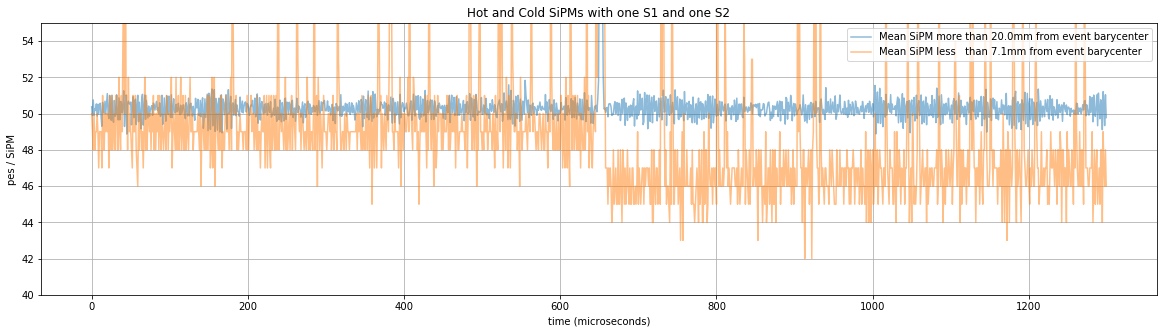

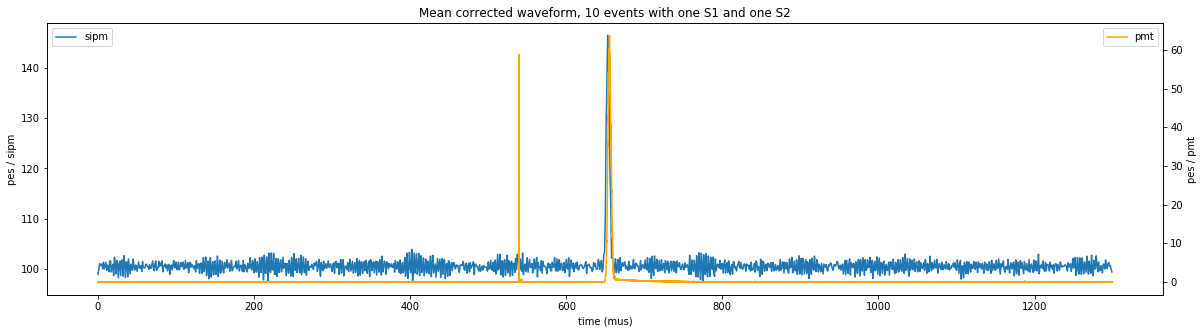

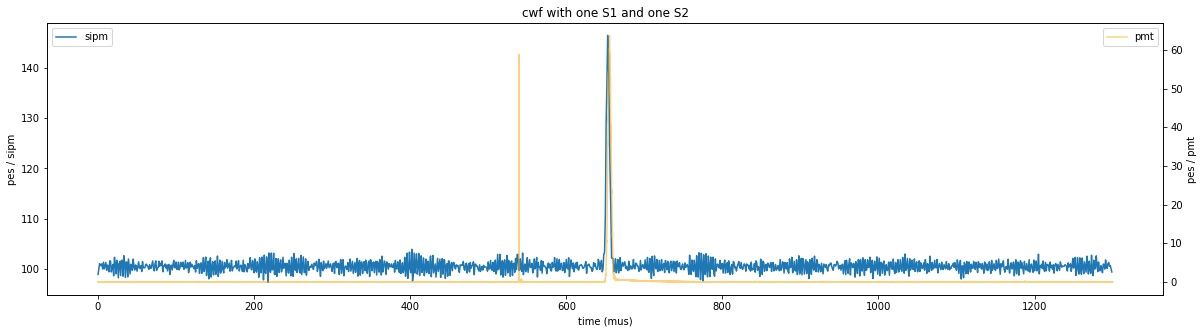

3056
2 12 1778


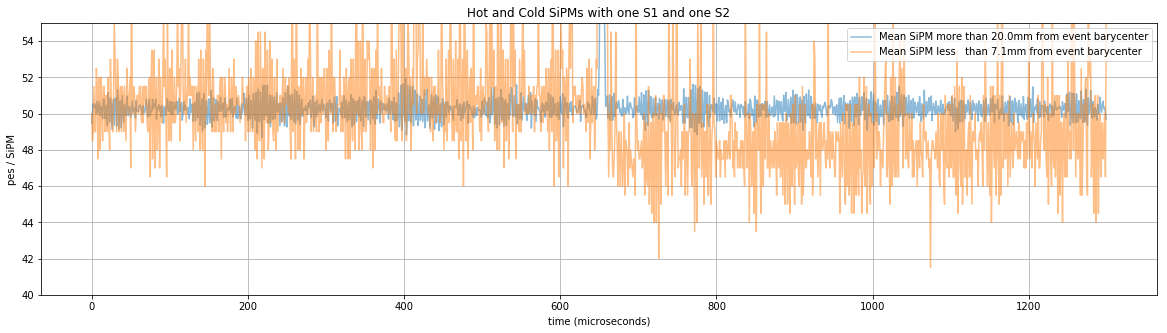

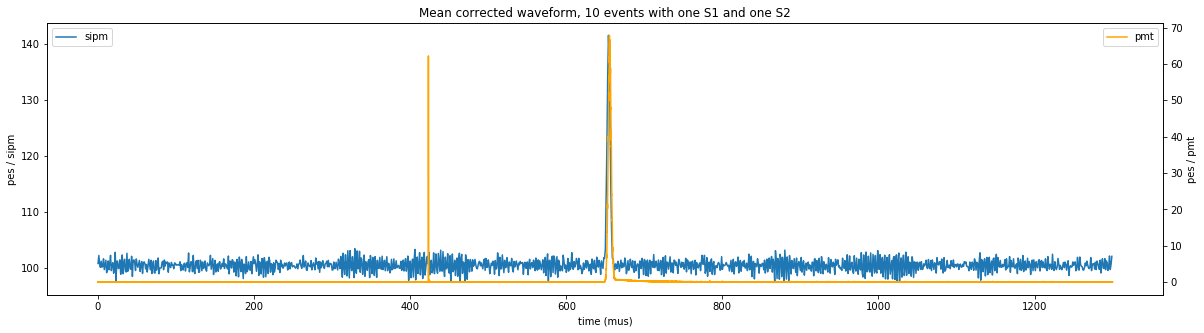

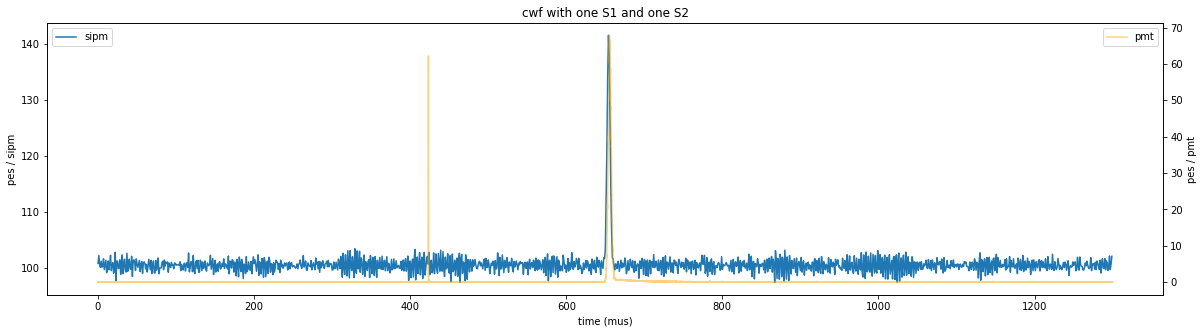

1533
2 12 1778


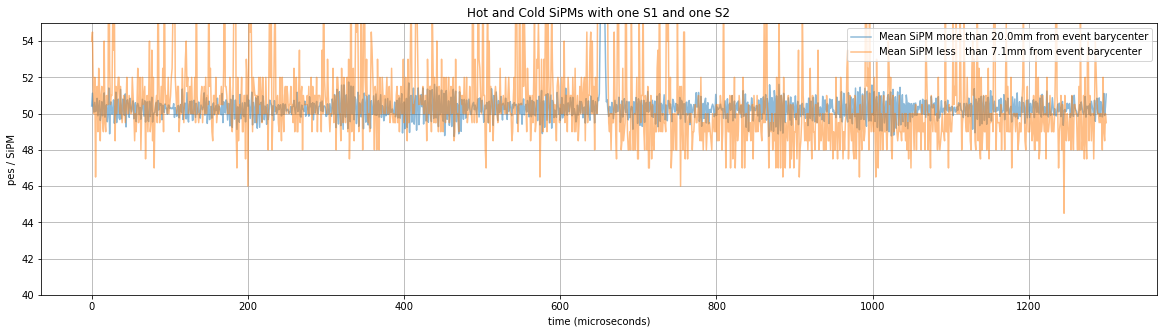

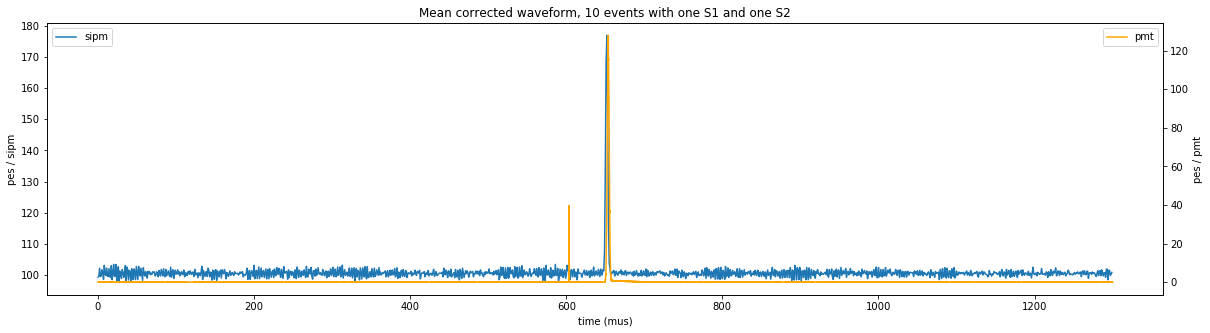

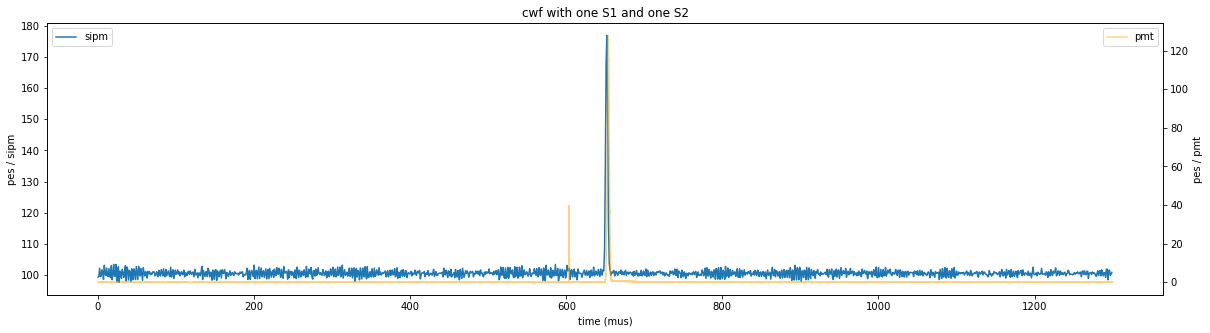

4076
2 12 1778


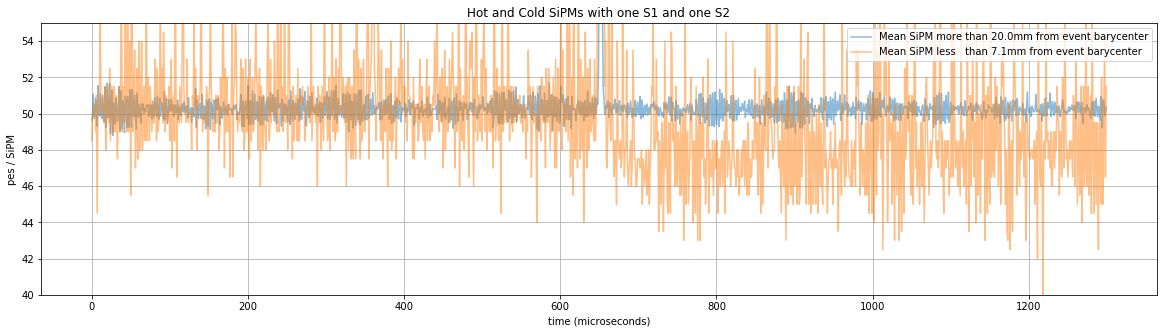

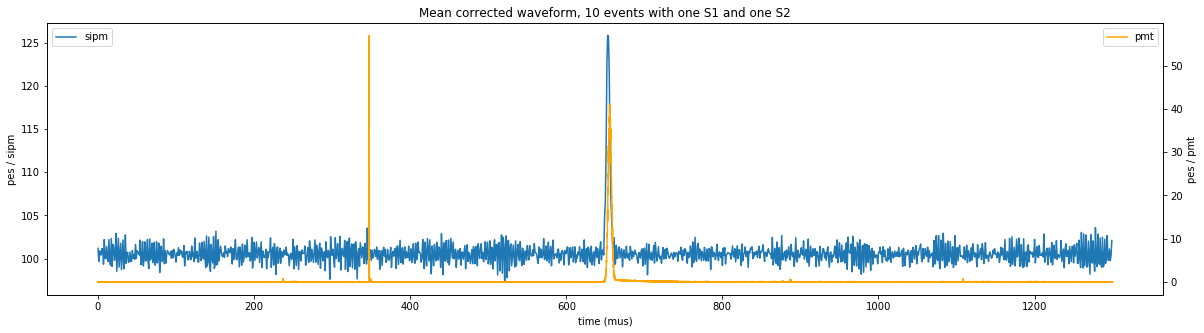

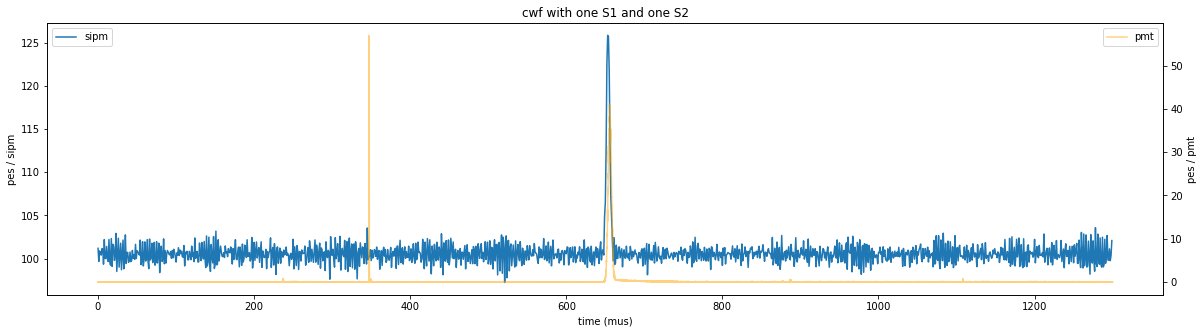

1214
1 12 1779


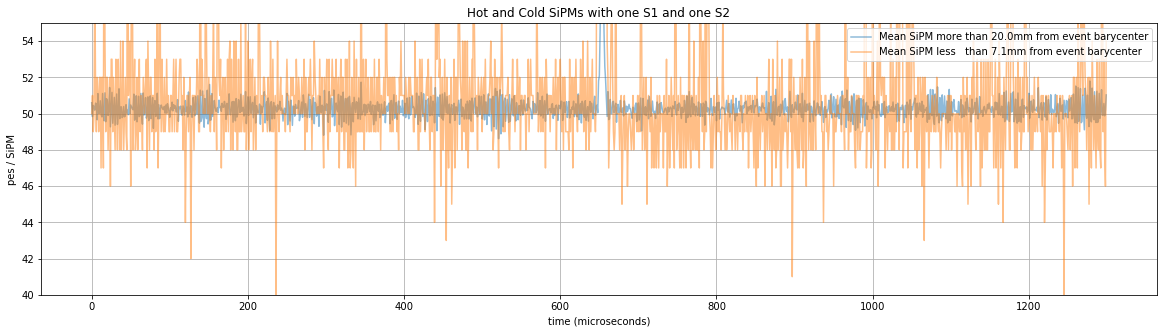

In [26]:
for ev in range(pevts):
    sipm_ms = sipm_sum[ev].mean(axis=0)
    pmt_ms  = pmt_sum[ev] .mean(axis=0)

    fig, ax1 = plt.subplots(figsize=(20,5))
    ax1.plot(range(len(sipm_ms)), sipm_ms, label='sipm')
    ax1.set_xlabel('time (mus)')
    ax1.set_ylabel('pes / sipm')
    ax1.legend(loc=2)
    ax2 = ax1.twinx()
    ax2.plot(np.array(range(len(pmt_ms))) / 1.0e3*25, pmt_ms, c='orange', label='pmt' )
    ax2.set_ylabel('pes / pmt')
    plt.title('Mean corrected waveform, ' + str(len(At)) + ' events with one S1 and one S2')
    ax2.legend()
    plt.show()

    fig, ax1 = plt.subplots(figsize=(20,5))
    ax1.plot(range(len(sipm_ms)), sipm_ms, label='sipm')
    ax1.set_xlabel('time (mus)')
    ax1.set_ylabel('pes / sipm')
    #ax1.set_ylim(0.025,.2)
    ax1.legend(loc=2)
    ax2 = ax1.twinx()
    ax2.plot(np.array(range(len(pmt_ms))) / 1.0e3*25, pmt_ms, c='orange', label='pmt', alpha=.5)
    ax2.set_ylabel('pes / pmt')
    #ax2.set_ylim(-.2,.8)
    plt.title('cwf with one S1 and one S2')
    ax2.legend()
    plt.show()
    
    plt.figure(figsize=(20,5))

    plt.plot(range(len(siwf_cold[ev][0])), siwf_cold[ev].mean(axis=0), label='Mean SiPM more than '  + str(warm_t) + 'mm from event barycenter', alpha=.5)
    #plt.plot(range(len(siwf_cold[ev].mean(axis=0))), siwf_warm[ev].mean(axis=0), label='Mean SiPM more than '  + str(hot_t)  + 'mm  and less than ' + str(warm_t) + ' from event barycenter', alpha=.5)
    plt.plot(range(len(siwf_cold[ev][0])), siwf_hot[ev].mean(axis=0), label='Mean SiPM less   than '+ str(hot_t)  + 'mm from event barycenter', alpha=.5)
    print(siwf_hot[ev].max())
    plt.xlabel('time (microseconds)')
    plt.ylabel('pes / SiPM')
    plt.title('Hot and Cold SiPMs with one S1 and one S2')
    plt.legend(loc=1)
    plt.ylim(40,55)
    plt.grid(True)
    
    print(len(siwf_hot[ev]),len(siwf_warm[ev]), len(siwf_cold[ev]))
    plt.show()

    
    

Cumulative Waveform

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,5))

sipm_ms = sipm_sum.mean(axis=0) / float(pevts)
pmt_ms  = pmt_sum .mean(axis=0) / float(pevts)

ax1.plot(range(len(sipm_ms)), sipm_ms, label='sipm')
ax1.set_xlabel('time (mus)')
ax1.set_ylabel('pes / sipm')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(np.array(range(len(pmt_ms))) / 1.0e3*25, pmt_ms, c='orange', label='pmt' )
ax2.set_ylabel('pes / pmt')
plt.title('Mean corrected waveform, ' + str(len(At)) + ' events with one S1 and one S2')
ax2.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(20,5))
ax1.plot(range(len(sipm_ms)), sipm_ms, label='sipm')
ax1.set_xlabel('time (mus)')
ax1.set_ylabel('pes / sipm')
ax1.set_ylim(0.02,.05)
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(np.array(range(len(pmt_ms))) / 1.0e3*25, pmt_ms, c='orange', label='pmt' )
ax2.set_ylabel('pes / pmt')
ax2.set_ylim(-.2,.2)
plt.title('Mean corrected waveform, ' + str(len(At)) + ' events with one S1 and one S2')
ax2.legend()
plt.show()

#### Cumulative waveform after S2

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,5))
start = 0
stop  = -125
Bmeansum = Bswf    .mean(axis=0)[start                   :stop                     ] / float(pevts)
Bms_pmt  = Bswf_pmt.mean(axis=0)[int(start * 1000 / 25.0): int(stop * 1000 / 25.0) ] / float(pevts)

ax1.plot(range(len(Bmeansum[np.nonzero(Bmeansum)])), 
         Bmeansum[np.nonzero(Bmeansum)], 
         label='sipm')

ax1.set_xlabel('microseconds after s2')
ax1.set_ylabel('pes / sipm')
ax1.legend(loc=2)
ax2 = ax1.twinx()

ax2.plot(np.array(range(len(Bms_pmt [np.nonzero(Bms_pmt) ]))) / 1.0e3*25, 
         Bms_pmt [np.nonzero(Bms_pmt )], 
         c='orange', label='pmt' )

ax2.set_ylabel('pes / pmt')
plt.title('Mean corrected waveforms after S2, ' + str(len(At)) + ' events')
ax2.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,3))
plt.hist(Bpes.mean(axis=1) / Bt, bins=pevts, alpha=.7)
plt.title('PEs after S2 (region B)')
plt.xlabel('PEs after S2 / SiPM / mus')
plt.grid(True)
plt.show()

binmin = min((Bspes / Bt * 2 / 1792).min(), (Bfpes / Bt * 2 / 1792).min())
binmax = max((Bspes / Bt * 2 / 1792).max(), (Bfpes / Bt * 2 / 1792).max())
normed=False
plt.figure(figsize=(15,3))
r = binmin, binmax
#r = .03, .036
plt.hist(Bspes / Bt * 2 / 1792, bins=bins, normed=normed, range=r, alpha=.5, label='1st  half of regB')
plt.hist(Bfpes / Bt * 2 / 1792, bins=bins, normed=normed, range=r, alpha=.5, label='2nd half of regB')
plt.grid(True)
plt.title('1st and 2nd half of region after S2 comparison')
plt.xlabel('PEs / SiPM / mus')
plt.legend()
plt.show()

In [ ]:
print('Here external means sipms at R >', ext_t)
binmin = min((Aint_pes[nza] / At[nza]).min(), (Aext_pes[nza] / At[nza]).min())
binmax = max((Aint_pes[nza] / At[nza]).max(), (Aext_pes[nza] / At[nza]).max())
binmin, binmax = (0.031, 0.038)
normed=False
plt.figure(figsize=(15,1.5))
plt.hist(Aext_pes[nza] / At[nza], bins=pevts, normed=normed, range=(binmin, binmax), alpha=.5, label='external sipms')
plt.hist(Aint_pes[nza] / At[nza], bins=pevts, normed=normed, range=(binmin, binmax), alpha=.5, label='internal sipms')
plt.grid(True)
plt.title('SiPMs between end of S1 and start of S2 (RegA)')
plt.xlabel('PEs Between S1 and S2 / SiPM / mus')
plt.legend()
plt.show()

#binmin = min((Bext_pes / Bt).min(), (Bint_pes / Bt).min())
#binmax = max((Bext_pes / Bt).max(), (Bint_pes / Bt).max())
normed=False
plt.figure(figsize=(15,1.5))
plt.hist(Bext_pes / Bt, bins=bins, normed=normed, range=(binmin, binmax), alpha=.5, label='external sipms')
plt.hist(Bint_pes / Bt, bins=bins, normed=normed, range=(binmin, binmax), alpha=.5, label='internal sipms')
plt.grid(True)
plt.title('SiPMs after S2 (RegB)')
plt.xlabel('PEs after S2 / SiPM / mus')
plt.legend()
plt.show()